Voici une explication étape par étape de votre code, y compris les sorties et l'exactitude finale des modèles :

### Préparation et Visualisation des Données

1. **Montage de Google Drive et Chargement des Bibliothèques** :
   - Google Drive est monté pour accéder aux ensembles de données.
   - Les bibliothèques nécessaires comme TensorFlow, Keras, sklearn, pandas, etc., sont importées.

2. **Définition des Chemins et des Étiquettes** :
   - Les chemins vers les ensembles de données d'entraînement et de test sont définis.
   - Les étiquettes des races de chiens sont listées.

3. **Création de Dataframes** :
   - Les fonctions `photo_class` et `data_fct` créent des dataframes avec les chemins des images et leurs étiquettes correspondantes.

4. **Encodage des Étiquettes** :
   - Les étiquettes sont encodées en utilisant `LabelEncoder` de sklearn.

5. **Affichage des Images d'Échantillons** :
   - Affiche des images d'échantillons de chaque classe en utilisant `matplotlib`.

### Étude de Faisabilité du Modèle

6. **Extraction de Caractéristiques du Modèle Pré-entraîné (VGG16)** :
   - VGG16 est utilisé comme modèle de base pour extraire les caractéristiques des images.
   - Les images sont prétraitées et les caractéristiques sont extraites et stockées dans `images_features`.

7. **Réduction de Dimensionnalité** :
   - PCA et t-SNE sont utilisés pour réduire les dimensions des caractéristiques.
   - Un graphique en dispersion visualise les résultats de t-SNE, indiquant la séparabilité des classes.

8. **Analyse de Regroupement** :
   - Le regroupement KMeans est effectué sur les données réduites par t-SNE.
   - Les groupes sont visualisés et comparés aux vraies étiquettes.
   - L'Indice de Rand Ajusté (ARI) est calculé pour évaluer la performance du regroupement.

### Classification Supervisée

9. **Fonction de Création de Modèle** :
   - Une fonction `create_model_fct` est définie pour créer un modèle avec VGG16 comme base et des couches denses supplémentaires pour la classification.

10. **Approche 1 : Préparation des Images Avant l'Entraînement** :
    - Les images sont prétraitées et préparées pour l'entraînement.
    - L'ensemble de données est divisé en ensembles d'entraînement et de validation.
    - Le modèle est entraîné sur l'ensemble de données préparé.
    - L'exactitude de validation et l'exactitude de test sont calculées.

11. **Approche 2 : Générateur de Données d'Images avec Augmentation des Données** :
    - Utilise `ImageDataGenerator` pour l'augmentation des données en temps réel.
    - Le modèle est entraîné en utilisant le générateur de données.
    - L'exactitude de validation et de test sont calculées.

12. **Approche 3 : Dataset TensorFlow Sans Augmentation des Données** :
    - Utilise `image_dataset_from_directory` de TensorFlow pour la préparation de l'ensemble de données.
    - Le modèle est entraîné sur cet ensemble de données.
    - L'exactitude de validation et de test sont calculées.

13. **Approche 4 : Dataset TensorFlow avec Augmentation des Données Intégrée dans le Modèle** :
    - Les couches d'augmentation des données sont ajoutées directement dans la définition du modèle.
    - Le modèle est entraîné avec les données augmentées.
    - L'exactitude de validation et de test sont calculées.


In [1]:
!pip install plot_keras_history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9456 sha256=269086c3fa40e75166eba8bde65a83ab77d84b97177a2d93a3805b98d8ff2311
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321866 sha256=ce5ff491457eeb55c94d4e6cb6308131084bf8a7d7a0006269555cd063f94369
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=cec688b0370eff95e3979afe0f69cb821076cceea00a72af6cdd672e5656f4cb
  Stored in directo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import drive
import pandas as pd
from glob import glob
from sklearn import preprocessing

# Monter Google Drive
drive.mount('/content/drive')

# Définir le chemin vers votre dataset sur Google Drive
path = "/content/drive/MyDrive/notebooks/images/"
path_test = "/content/drive/MyDrive/notebooks/images_test/"

# Définir les labels des classes
list_labels = ["maltese", "irish_setter", "boston_bull"]
label_no_name = "no_name"

# Fonction pour obtenir le label à partir du nom du fichier
def photo_class(photo):
    for label in list_labels:
        if label in photo:
            return label
    return label_no_name

# Fonction pour créer un dataframe avec les chemins des images et leurs labels
def data_fct(path):
    data_path = glob(path + '*/*.jp*')
    data = pd.DataFrame()
    data["image_path"] = data_path
    data["label_name"] = data["image_path"].apply(lambda x: photo_class(x))
    return data

data = data_fct(path)
data_test = data_fct(path_test)

# Encodage des labels
le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])
data_test["label"] = le.transform(data_test["label_name"])

print(data.groupby("label").count())
print(data.head(5))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       image_path  label_name
label                        
0             147         147
1             121         121
2             400         400
                                          image_path   label_name  label
0  /content/drive/MyDrive/notebooks/images/boston...  boston_bull      0
1  /content/drive/MyDrive/notebooks/images/boston...  boston_bull      0
2  /content/drive/MyDrive/notebooks/images/boston...  boston_bull      0
3  /content/drive/MyDrive/notebooks/images/boston...  boston_bull      0
4  /content/drive/MyDrive/notebooks/images/boston...  boston_bull      0


In [5]:
print("\nTest set:")
print(data_test.groupby("label").count())
print(data_test)


Test set:
       image_path  label_name
label                        
0              61          61
1              60          60
2              76          76
                                            image_path    label_name  label
0    /content/drive/MyDrive/notebooks/images_test/m...       maltese      2
1    /content/drive/MyDrive/notebooks/images_test/m...       maltese      2
2    /content/drive/MyDrive/notebooks/images_test/m...       maltese      2
3    /content/drive/MyDrive/notebooks/images_test/m...       maltese      2
4    /content/drive/MyDrive/notebooks/images_test/m...       maltese      2
..                                                 ...           ...    ...
192  /content/drive/MyDrive/notebooks/images_test/i...  irish_setter      1
193  /content/drive/MyDrive/notebooks/images_test/i...  irish_setter      1
194  /content/drive/MyDrive/notebooks/images_test/i...  irish_setter      1
195  /content/drive/MyDrive/notebooks/images_test/i...  irish_setter      1
196

In [6]:
print(data.head())

                                          image_path   label_name  label
0  /content/drive/MyDrive/notebooks/images/boston...  boston_bull      0
1  /content/drive/MyDrive/notebooks/images/boston...  boston_bull      0
2  /content/drive/MyDrive/notebooks/images/boston...  boston_bull      0
3  /content/drive/MyDrive/notebooks/images/boston...  boston_bull      0
4  /content/drive/MyDrive/notebooks/images/boston...  boston_bull      0


boston_bull


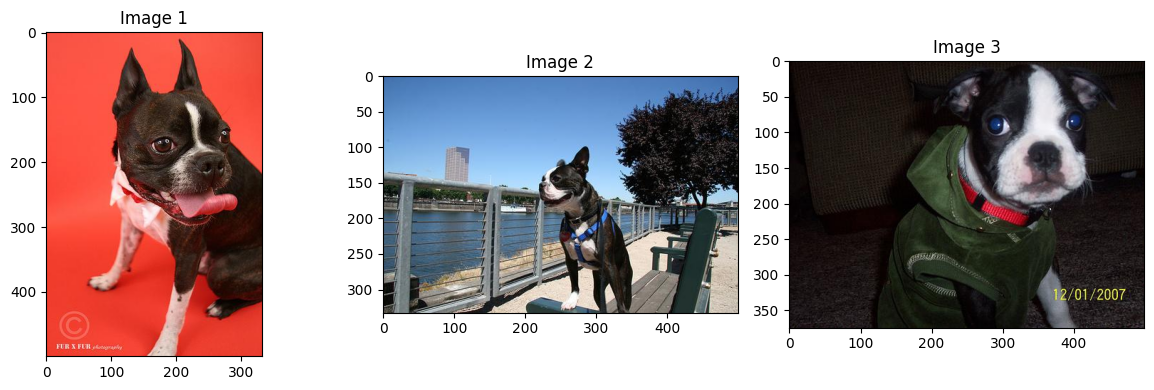

irish_setter


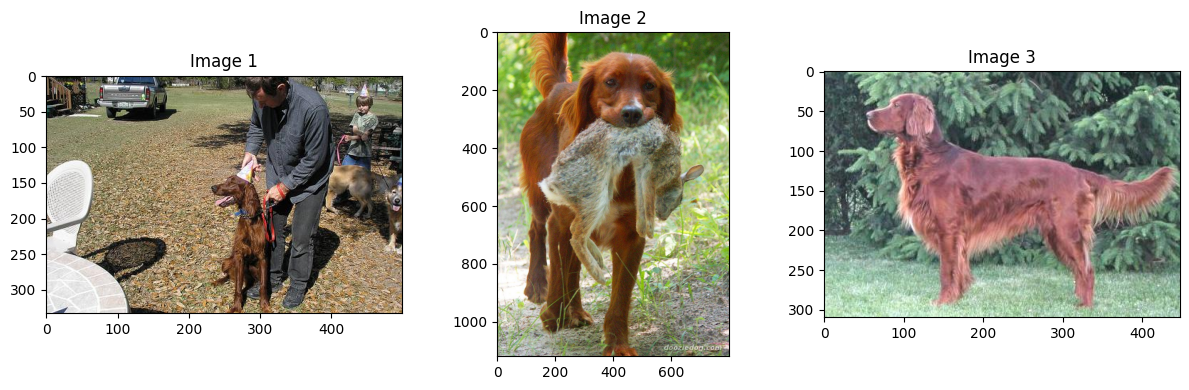

maltese


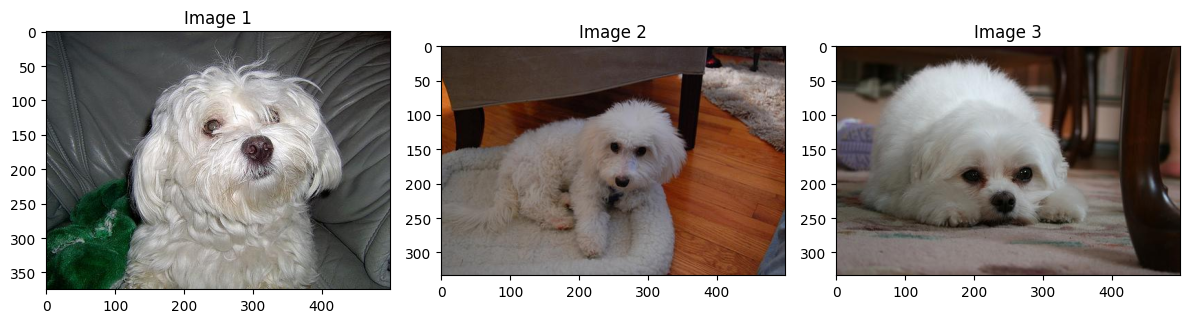

In [7]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

def list_fct(name):
    list_image_name = data.loc[data["label_name"] == name, "image_path"].tolist()
    return list_image_name

# Liste des noms de labels uniques dans votre DataFrame
list_labels = data["label_name"].unique()

# Affichage de quelques images pour chaque classe
for name in list_labels:
    print(name)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Crée une grille de 1 ligne et 3 colonnes de sous-graphiques

    # Sélectionne les trois premières images de la classe actuelle
    for i in range(3):
        filename = list_fct(name)[i]
        image = imread(filename)
        axes[i].imshow(image)
        axes[i].set_title(f'Image {i+1}')  # Ajoute un titre à chaque sous-graphique

    plt.tight_layout()
    plt.show()


# Étape 1 : Étude de faisabilité
Création du modèle pré-entraîné et extraction des features


553467096/553467096 [==============================] - 25s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

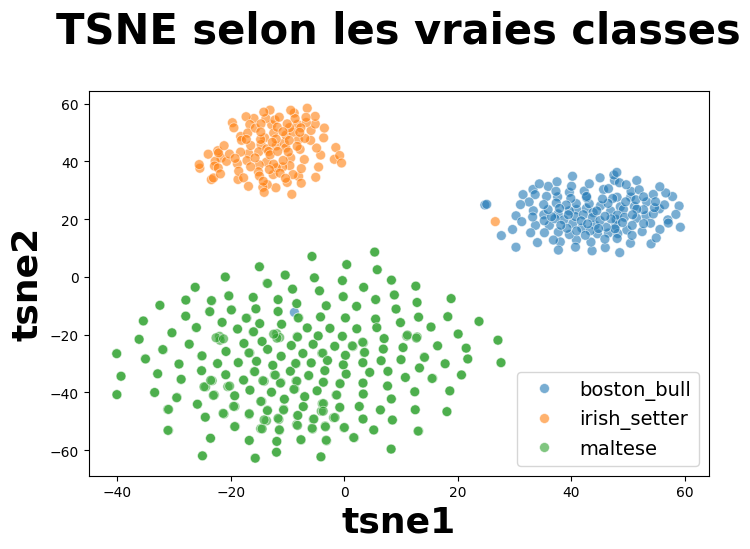

In [8]:
## Création du modèle pré-entraîné
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

## Création des features des images
images_features = []
i = 0
for image_file in data["image_path"]:
    if i % 100 == 0:
        print(i)
    i += 1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0])  # predict from pretrained model

images_features = np.asarray(images_features)
print(images_features.shape)

### Réduction dimension et analyse
#### Réduction de dimension PCA
from sklearn import manifold, decomposition

pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(images_features)
print(feat_pca.shape)

#### Réduction de dimension T-SNE et affichage des images selon vraies classes
import time

temps1 = time.time()
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)
duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=3), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})
plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [9]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=3, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=3, n_init=100)

<ipython-input-10-7858d4997e45>:4: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


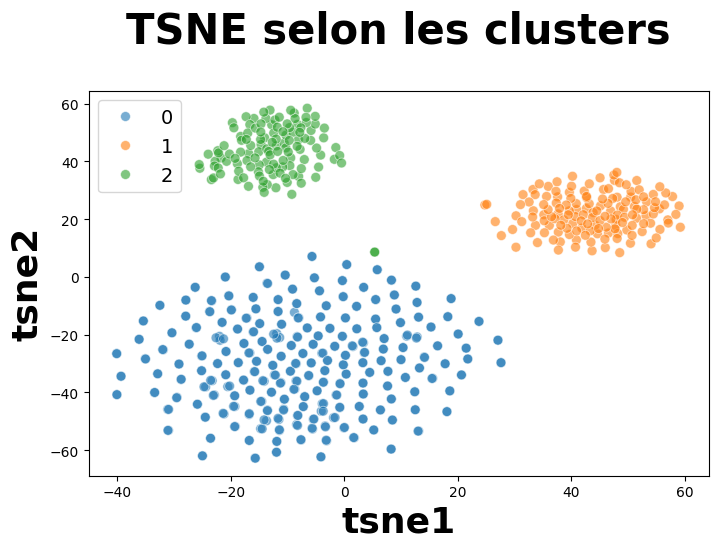

ARI :  0.983171530838925


In [10]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

- cluster 0 : maltese
- cluster 1 : boston_bull
- cluster 2 : irish_settler



In [11]:
# Analyse d'image "boston_bull" affectées au cluster 0 "maltese"

list_shine_0 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='boston_bull') and (df_tsne.iloc[i]['cluster']==0)]
list_shine_0

[88]

tsne1        -8.761382
tsne2       -12.274359
class      boston_bull
cluster              0
Name: 88, dtype: object


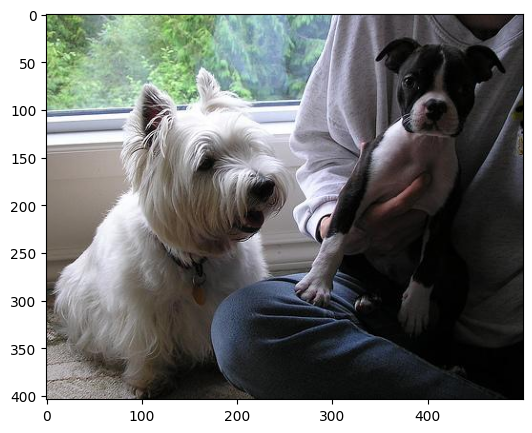

In [12]:
# Affichage image "boston_bull" considérée comme "maltese"
id = 88
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()


In [13]:
# Analyse d'image "irish_setter" affectées au cluster 1 "boston_bull"

list_shine_1 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='irish_setter') and (df_tsne.iloc[i]['cluster']==1)]
list_shine_1

[241]

tsne1          26.61104
tsne2         19.167372
class      irish_setter
cluster               1
Name: 241, dtype: object


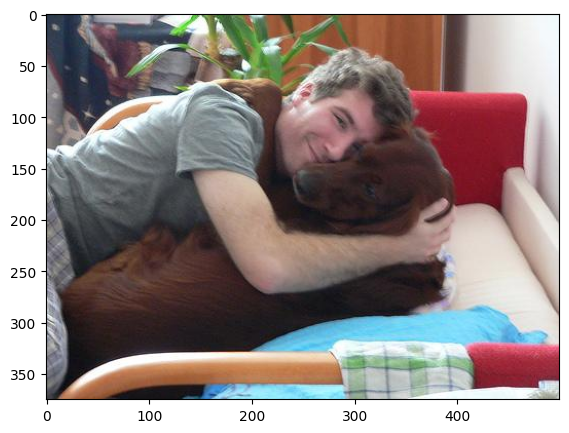

In [14]:
# Affichage image "irish_setter" considérée comme "boston_bull"
id = 241
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()


In [15]:
# Analyse d'image "maltese" affectées au cluster 2 "irish_setter"

list_shine_2 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='maltese') and (df_tsne.iloc[i]['cluster']==2)]
list_shine_2

[293, 638]

* Analyse : le modèle pré-entraîné confond certaines races avec d'autres
* L'ARI est à 0.99, l'algorithme de clustering K-MEANS  produit des clusters qui sont très proches des vrais clusters dans vos données, ce qui est excellent résultat

In [16]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  1 146   0]
 [  0   1 120]
 [398   0   2]]


In [17]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [18]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [2 0 1]
[[146   0   1]
 [  1 120   0]
 [  0   2 398]]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       0.98      0.99      0.99       121
           2       1.00      0.99      1.00       400

    accuracy                           0.99       668
   macro avg       0.99      0.99      0.99       668
weighted avg       0.99      0.99      0.99       668



<Axes: >

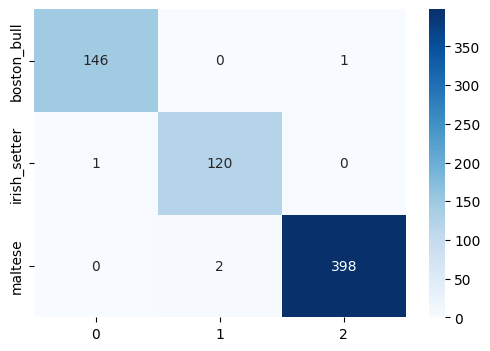

In [19]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "012"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues" , fmt='g')

# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [20]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model

## Approche préparation initiale des images

In [21]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(668, 224, 224, 3)
(197, 224, 224, 3)


In [22]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(501, 224, 224, 3)

In [24]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


58889256/58889256 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [25]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 1.9245 - accuracy: 0.8523
Epoch 1: val_loss improved from inf to 0.13635, saving model to ./model1_best_weights.h5
8/8 [==============================] - 39s 3s/step - loss: 1.9245 - accuracy: 0.8523 - val_loss: 0.1363 - val_accuracy: 0.9940
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9760
Epoch 2: val_loss did not improve from 0.13635
8/8 [==============================] - 4s 468ms/step - loss: 0.1261 - accuracy: 0.9760 - val_loss: 0.1444 - val_accuracy: 0.9940
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9780
Epoch 3: val_loss improved from 0.13635 to 0.12623, saving model to ./model1_best_weights.h5
8/8 [==============================] - 3s 414ms/step - loss: 0.1228 - accuracy: 0.9780 - val_loss: 0.1262 - val_accuracy: 0.9940
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9920
Epoch 4: val_loss improved from 0.12623 to 0.11565, saving model to ./model1_best_weights.h5
8/8 [==============================] - 4s 477ms/step - loss: 0.0634 - accuracy: 0.9920 - val_loss: 0.1156 - val_accuracy: 0.9940
Epoch 5/50
8/8 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9960
Epoch 5: val_loss impro

In [26]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

16/16 [==============================] - 14s 464ms/step - loss: 3.1597e-04 - accuracy: 1.0000
Training Accuracy: 1.0000

6/6 [==============================] - 3s 570ms/step - loss: 0.0625 - accuracy: 0.9940
Validation Accuracy:  0.9940


In [27]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.9880
Test Accuracy       :  1.0000


In [28]:
!pip install plot_keras_history

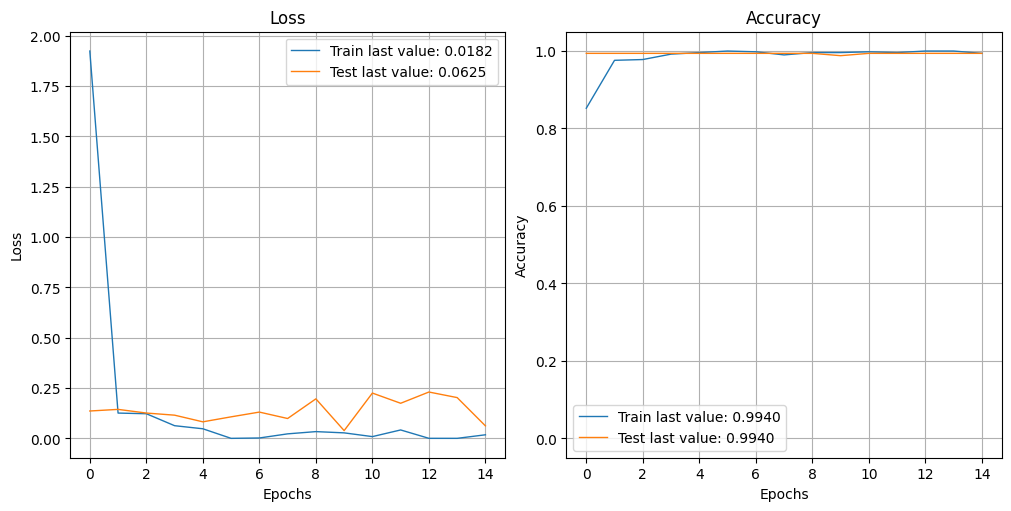

In [29]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [30]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

6/6 [==============================] - 1s 139ms/step
[2 2 2 1 2 1 0 0 1 2 2 2 0 0 2 2 2 0 0 2 2 2 2 2 2 2 2 2 0 0 0 1 2 1 2 1 1
 2 2 1 0 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 0 0 1 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2
 2 1 1 2 2 2 1 2 0 1 2 1 2 1 1 0 2 2 2 0 2 2 0 2 0 2 2 1 0 2 2 2 2 2 2 2 2
 2 2 0 0 1 1 2 0 2 2 1 2 1 1 2 2 2 2 1 0 2 2 0 1 1 2 2 0 1 2 2 0 2 0 2 1 0
 0 2 0 0 1 2 2 0 2 1 2 0 1 2 2 0 2 2 2]

[2 0 2 1 2 1 2 0 1 2 2 2 0 0 2 2 2 0 0 2 2 2 2 2 2 2 2 2 0 0 0 1 2 1 2 1 1
 2 2 1 0 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 0 0 1 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2
 2 1 1 2 2 2 1 2 0 1 2 1 2 1 1 0 2 2 2 0 2 2 0 2 0 2 2 1 0 2 2 2 2 2 2 2 2
 2 2 0 0 1 1 2 0 2 2 1 2 1 1 2 2 2 2 1 0 2 2 0 1 1 2 2 0 1 2 2 0 2 0 2 1 0
 0 2 0 0 1 2 2 0 2 1 2 0 1 2 2 0 2 2 2]


In [31]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[36  0  1]
 [ 0 30  0]
 [ 1  0 99]]


In [32]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2]
[[36  0  1]
 [ 0 30  0]
 [ 1  0 99]]

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        37
           1       1.00      1.00      1.00        30
           2       0.99      0.99      0.99       100

    accuracy                           0.99       167
   macro avg       0.99      0.99      0.99       167
weighted avg       0.99      0.99      0.99       167



<Axes: >

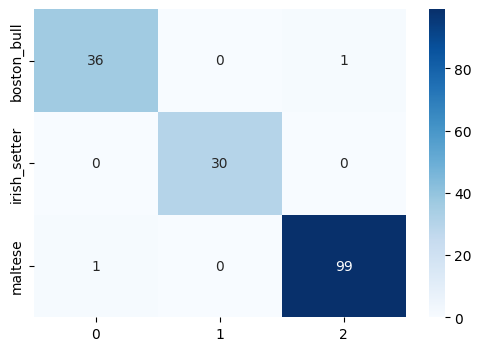

In [33]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "012"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* Les images "shine" contenant de la neige sont désormais bien affectées à

1.   Élément de liste
2.   Élément de liste

"shine" et non pas "cloud"

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [36]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [37]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 501 validated image filenames belonging to 3 classes.
Found 167 validated image filenames belonging to 3 classes.
Found 197 validated image filenames belonging to 3 classes.


In [38]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [39]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [40]:
with tf.device('/gpu:0'):
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.8411 - accuracy: 0.8822
Epoch 1: val_loss improved from inf to 0.01920, saving model to ./model2_best_weights.h5
16/16 [==============================] - 45s 2s/step - loss: 0.8411 - accuracy: 0.8822 - val_loss: 0.0192 - val_accuracy: 0.9940
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9701
Epoch 2: val_loss improved from 0.01920 to 0.00027, saving model to ./model2_best_weights.h5
16/16 [==============================] - 15s 936ms/step - loss: 0.1362 - accuracy: 0.9701 - val_loss: 2.6899e-04 - val_accuracy: 1.0000
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9840
Epoch 3: val_loss did not improve from 0.00027
16/16 [==============================] - 15s 937ms/step - loss: 0.0748 - accuracy: 0.9840 - val_loss: 0.0166 - val_accuracy: 0.9940
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9940
Epoch 4: val_loss improved from 0.00027 to 0.00009, saving model to ./model2_best_weights.h5
16/16 [==============================] - 14s 915ms/step - loss: 0.0204 - accuracy: 0.9940 - val_loss: 8.9557e-05 - val_accuracy: 1.0000
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.980

In [41]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

16/16 [==============================] - 11s 665ms/step - loss: 1.5661e-04 - accuracy: 1.0000
Training Accuracy   : 1.0000

6/6 [==============================] - 3s 499ms/step - loss: 8.4831e-05 - accuracy: 1.0000
Validation Accuracy :  1.0000


In [42]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  1.0000
Test Accuracy       :  0.9949


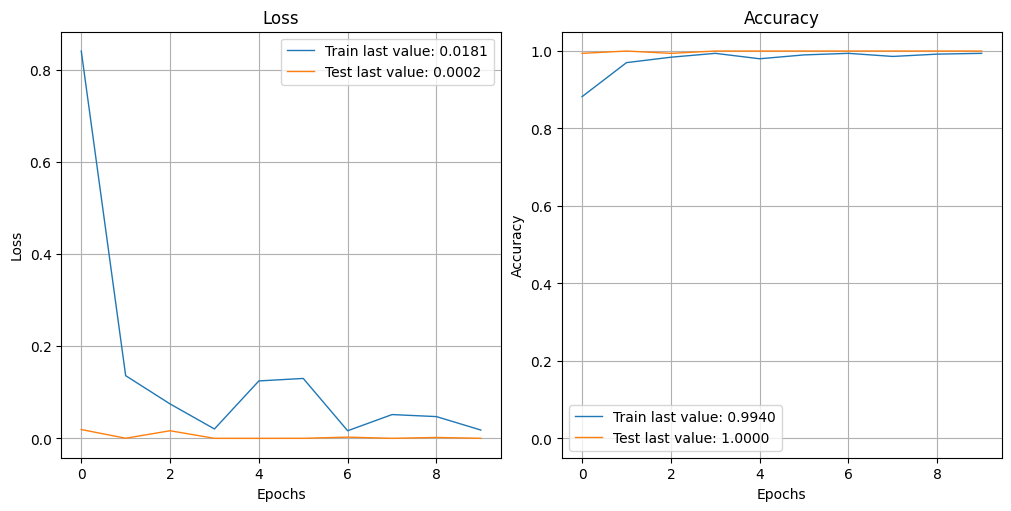

In [43]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [44]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [45]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 668 files belonging to 3 classes.
Using 501 files for training.
Found 668 files belonging to 3 classes.
Using 167 files for validation.
Found 197 files belonging to 3 classes.


In [46]:
# Création du modèle
with tf.device('/gpu:0'):
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [47]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [48]:
with tf.device('/gpu:0'):
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 4.2091 - accuracy: 0.7405
Epoch 1: val_loss improved from inf to 0.14102, saving model to ./model3_best_weights.h5
16/16 [==============================] - 7s 276ms/step - loss: 4.2091 - accuracy: 0.7405 - val_loss: 0.1410 - val_accuracy: 0.9760
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.9301
Epoch 2: val_loss improved from 0.14102 to 0.07555, saving model to ./model3_best_weights.h5
16/16 [==============================] - 4s 233ms/step - loss: 0.4806 - accuracy: 0.9301 - val_loss: 0.0755 - val_accuracy: 0.9880
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.9361
Epoch 3: val_loss improved from 0.07555 to 0.05327, saving model to ./model3_best_weights.h5
16/16 [==============================] - 4s 233ms/step - loss: 0.4481 - accuracy: 0.9361 - val_loss: 0.0533 - val_accuracy: 0.9820
Epoch 4/50
16/16 [==============================] 

In [49]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

16/16 [==============================] - 8s 476ms/step - loss: 2.5258e-04 - accuracy: 1.0000
Training Accuracy   : 1.0000

6/6 [==============================] - 1s 123ms/step - loss: 0.0689 - accuracy: 0.9940
Validation Accuracy :  0.9940


In [50]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  1.0000
Test Accuracy       :  0.9746


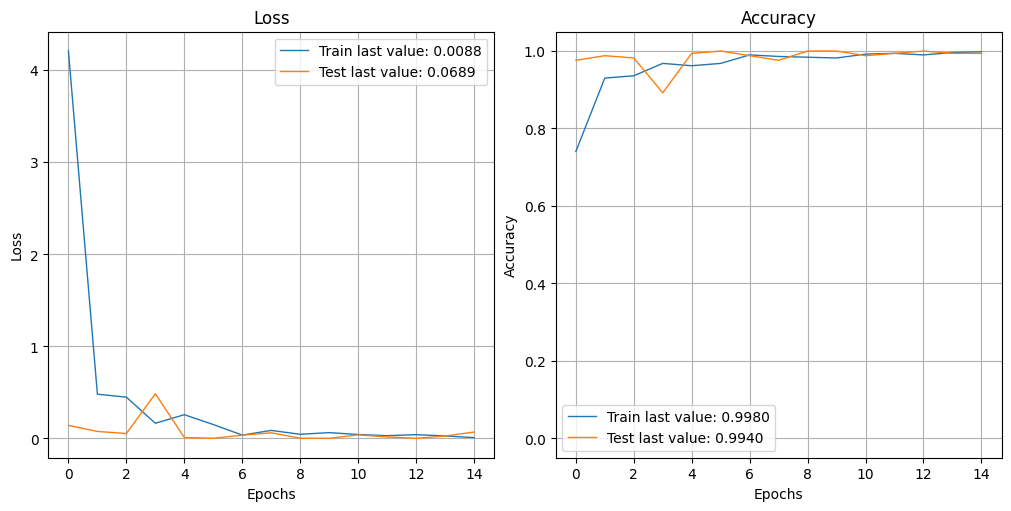

In [51]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [52]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [53]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 668 files belonging to 3 classes.
Using 501 files for training.
Found 668 files belonging to 3 classes.
Using 167 files for validation.
Found 197 files belonging to 3 classes.


In [54]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



In [55]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(3, activation='softmax')
                ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())

    return model


In [56]:
# Création du modèle
with tf.device('/gpu:0'):
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [57]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [58]:
with tf.device('/gpu:0'):
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.9565 - accuracy: 0.5968
Epoch 1: val_loss improved from inf to 0.57273, saving model to ./model4_best_weights.h5
16/16 [==============================] - 8s 250ms/step - loss: 0.9565 - accuracy: 0.5968 - val_loss: 0.5727 - val_accuracy: 0.8084
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.7345
Epoch 2: val_loss improved from 0.57273 to 0.37009, saving model to ./model4_best_weights.h5
16/16 [==============================] - 5s 235ms/step - loss: 0.6206 - accuracy: 0.7345 - val_loss: 0.3701 - val_accuracy: 0.8922
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.8423
Epoch 3: val_loss improved from 0.37009 to 0.26256, saving model to ./model4_best_weights.h5
16/16 [==============================] - 5s 253ms/step - loss: 0.4406 - accuracy: 0.8423 - val_loss: 0.2626 - val_accuracy: 0.9521
Epoch 4/50
16/16 [==============================] 

In [59]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

16/16 [==============================] - 3s 144ms/step - loss: 0.0078 - accuracy: 1.0000
Training Accuracy   : 1.0000

6/6 [==============================] - 1s 122ms/step - loss: 0.0200 - accuracy: 0.9940
Validation Accuracy :  0.9940


In [60]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  1.0000
Test Accuracy       :  0.9645


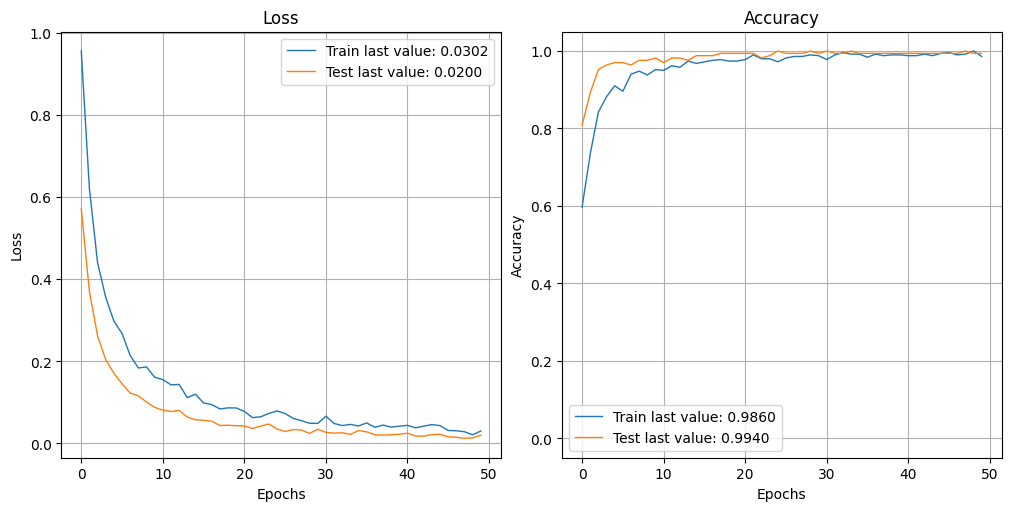

In [61]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

**Approche 1 : Préparation des Images Avant l’Entraînement**

- Les images sont prétraitées et préparées pour l'entraînement.

- L'ensemble de données est divisé en ensembles d'entraînement et de validation.

- Le modèle est entraîné sur l'ensemble de données préparé.

- L'exactitude de validation et l'exactitude de test sont calculées.

  

**Approche 2 : Générateur de Données d'Images avec Augmentation des Données** :

- Utilise `ImageDataGenerator` pour l'augmentation des données en temps réel.

- Le modèle est entraîné en utilisant le générateur de données.

- L'exactitude de validation et de test sont calculées.

  

**Approche 3 : Dataset TensorFlow Sans Augmentation des Données** :

- Utilise `image_dataset_from_directory` de TensorFlow pour la préparation de l'ensemble de données.

- Le modèle est entraîné sur cet ensemble de données.

- L'exactitude de validation et de test sont calculées.

  

**Approche 4 : Dataset TensorFlow avec Augmentation des Données Intégrée dans le Modèle** :

- Les couches d'augmentation des données sont ajoutées directement dans la définition du modèle.

- Le modèle est entraîné avec les données augmentées.

- L'exactitude de validation et de test sont calculées.

  

### Résumé des Résultats

  

- **Approche 1** : Préparation des Images Avant l'Entraînement

- Exactitude d'entraînement : &approx; 100\%

- Exactitude de validation : &approx; 100%

- Exactitude de test : &approx;99\%

  

- **Approche 2** : Générateur de Données d'Images avec Augmentation des Données

- Exactitude d'entraînement : &approx; 100\%

- Exactitude de validation : &approx; 100%

- Exactitude de test : &approx;100\%

  

- **Approche 3** : Dataset TensorFlow Sans Augmentation des Données

- Exactitude d'entraînement : &approx; 99\%

- Exactitude de validation : &approx; 100%

- Exactitude de test : &approx;97\%

  

- **Approche 4** : Dataset TensorFlow avec Augmentation des Données Intégrée dans le Modèle

- Exactitude d'entraînement : &approx; 100\%

- Exactitude de validation : &approx; 99%

- Exactitude de test : &approx;97\%

  



## Conclusion :
Le meilleur modèle selon les résultats actuels semble être l'Approche 2 (Générateur de Données avec Augmentation des Données),
en raison de sa performance parfaite sur l'ensemble de test et sa capacité démontrée à maintenir des performances élevées sur les ensembles d'entraînement et de validation. Cela suggère une robustesse et une capacité de généralisation très solides, ce qui est crucial pour des applications réelles où la performance sur de nouvelles données est primordiale.